## Section H: Multi-fidelity Bayesian Optimisation - Short Illustration/Example

Multi-fidelity Bayesian optimisation (MF-BO) is a good tool in optimisation senarios where cheap, imperfect evaluations (low fidelity) and expensive, accurate avaluations (high fidelity) are avaiable. MFBO obtains the best high fidelity optimum with fewer expensive runs by incorporating the lower fidelity evaluations. 

MFBO helps most when the lower fidelity evaluations is meaningfully correlated with high fidelity evaluations and much cheaper. If low fidelity is weakly correlated or nearly as expensive, the advantage shrinks.

### Importing Relevant Packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [1]:
# If you're running this in a clean environment, uncomment:
# %pip install botorch gpytorch

import math
import os
import time
from dataclasses import dataclass

import torch
import matplotlib.pyplot as plt

# BoTorch / GPyTorch
import gpytorch
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.optim.optimize import optimize_acqf
from botorch.acquisition import PosteriorMean
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.optim.initializers import gen_one_shot_kg_initial_conditions

torch.manual_seed(0)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions

In [2]:
def set_mpl_defaults():
    plt.rcParams["figure.figsize"] = (8, 3.2)
    plt.rcParams["axes.grid"] = True
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False

set_mpl_defaults()


### Multi-Fidelity BO Overview

There is an objective $ f(x) $ to optimise, but it is expensive to evaluate. However, cheaper approximations are also available (lower fidelity).

BoTorch represents fidelity (both continuous and discrete) as extra input dimensions. A common continuous-fidelity view is:

- you can evaluate $ f(x, s) $ where  
  - $x$ = input space
  - $s \in [0, 1]$ = fidelity (0 = cheapest, 1 = best / target fidelity)

Typically:

- cost increases with fidelity: $c(s)$ is increasing in $s$,
- fidelity increases “accuracy” of $f(x,s)$ as $s\to 1$.

MF-BO tries to pick **(x, s)** each step to make the best use of a given resource/budget.

There are two common MF regimes (BOTorch handles both): 

- Continuous fidelity: $s$ is numerical/real-valued:
   - % training data, number of epochs,
   - mesh resolution,
   - DFT thresholds / basis-set interpolation.

- Discrete fidelities: 
   - method A / method B / method C,
   - different instruments / labs,
   - different computational protocols.




### A Multi-fidelity BO example
#### 0. Creation of a test function ``f_mf()``

```python
def f_hi(x: torch.Tensor) -> torch.Tensor:
    return (
        torch.sin(2 * math.pi * x)
        + 0.35 * torch.cos(6 * math.pi * x)
        + 0.3 * x
    )

def bias(x: torch.Tensor) -> torch.Tensor:
    return 0.6 * torch.sin(4 * math.pi * x + 0.3) - 0.2 * x

def noise_std(s: torch.Tensor) -> torch.Tensor:
    # low fidelity -> larger noise
    return 0.03 + 0.25 * (1.0 - s)

def f_mf(X: torch.Tensor, add_noise: bool = True) -> torch.Tensor:
    '''
    Multi-fidelity objective.
    X: n x 2 tensor, columns [x, s]
    returns: n x 1 tensor
    '''

    x = X[..., [0]]
    s = X[..., [1]]
    y = f_hi(x) + (1.0 - s) * bias(x)
    if add_noise:
        eps = torch.randn_like(y)
        y = y + noise_std(s) * eps
    return y

xs = torch.linspace(0, 1, 400, **tkwargs).unsqueeze(-1)
s_list = [0.2, 0.5, 1.0]
plt.figure()
for s_val in s_list:
    X_plot = torch.cat([xs, torch.full_like(xs, s_val)], dim=-1)
    plt.plot(xs.cpu(), f_mf(X_plot, add_noise=False).cpu(), label=f"s={s_val}")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x, s)")
plt.title("True objective slices at different fidelities")
plt.show()
```

Our test function takes an input variable $x \in [0,1]$ and a fidelity $s \in [0,1]$.

A synthetic 'high fidelity' function $f_{hi}(x)$ (when $s = 1$) is created. The low fidelity function takes:

- **bias** that shrinks as $s \to 1$
- **noise** that shrinks as $s \to 1$

to make the evaluations cheaper but less reliable.



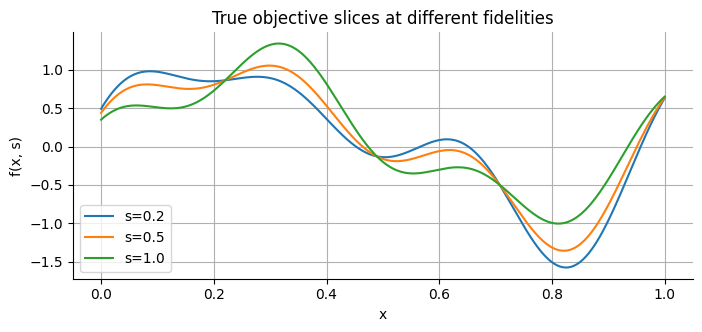

In [4]:
def f_hi(x: torch.Tensor) -> torch.Tensor:
    return (
        torch.sin(2 * math.pi * x)
        + 0.35 * torch.cos(6 * math.pi * x)
        + 0.3 * x
    )

def bias(x: torch.Tensor) -> torch.Tensor:
    return 0.6 * torch.sin(4 * math.pi * x + 0.3) - 0.2 * x

def noise_std(s: torch.Tensor) -> torch.Tensor:
    # low fidelity -> larger noise
    return 0.03 + 0.25 * (1.0 - s)

def f_mf(X: torch.Tensor, add_noise: bool = True) -> torch.Tensor:
    '''
    Multi-fidelity objective.
    X: n x 2 tensor, columns [x, s]
    returns: n x 1 tensor
    '''

    x = X[..., [0]]
    s = X[..., [1]]
    y = f_hi(x) + (1.0 - s) * bias(x)
    if add_noise:
        eps = torch.randn_like(y)
        y = y + noise_std(s) * eps
    return y

xs = torch.linspace(0, 1, 400, **tkwargs).unsqueeze(-1)
s_list = [0.2, 0.5, 1.0]
plt.figure()
for s_val in s_list:
    X_plot = torch.cat([xs, torch.full_like(xs, s_val)], dim=-1)
    plt.plot(xs.cpu(), f_mf(X_plot, add_noise=False).cpu(), label=f"s={s_val}")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x, s)")
plt.title("True objective slices at different fidelities")
plt.show()


#### 1. Training Data Points

In MF-BO you usually start with a small set of observations spread across the space and fidelities.  

We can usually obtain:
- many cheap evaluations (to cover space),
- a few expensive evaluations (to anchor the target fidelity).

For this example: 
- `n_low` - 5 points with random $s \in [0.05, 0.8]$
- `n_high` - 2 points with $s = 1$

Here, we have implimented an arbitraty cost function to track the cost over evaluations.

```python
def cost(s: torch.Tensor) -> torch.Tensor:
    return 0.1 + 2.0 * (s ** 2)

def generate_initial_data(n_low: int = 5, n_high: int = 2):
    # Low-fidelity points
    x_low = torch.rand(n_low, 1, **tkwargs)
    s_low = 0.05 + 0.75 * torch.rand(n_low, 1, **tkwargs)  # in [0.05, 0.8]
    X_low = torch.cat([x_low, s_low], dim=-1)

    # High-fidelity points
    x_high = torch.rand(n_high, 1, **tkwargs)
    s_high = torch.ones(n_high, 1, **tkwargs)
    X_high = torch.cat([x_high, s_high], dim=-1)

    X = torch.cat([X_low, X_high], dim=0)
    Y = f_mf(X, add_noise=True)

    return X, Y

train_X, train_Y = generate_initial_data()

# Visualise observations (colour by fidelity)
plt.figure()
plt.scatter(train_X[:, 0].cpu(), train_Y[:, 0].cpu(), c=train_X[:, 1].cpu())
plt.xlabel("x")
plt.ylabel("observed y")
plt.title("Initial observations (colour = fidelity s)")
plt.colorbar(label="s")
plt.show()

# Also track cost spent so far:
spent = cost(train_X[:, [1]]).sum().item()
print(f"Initial total simulated cost: {spent:.3f}")
```

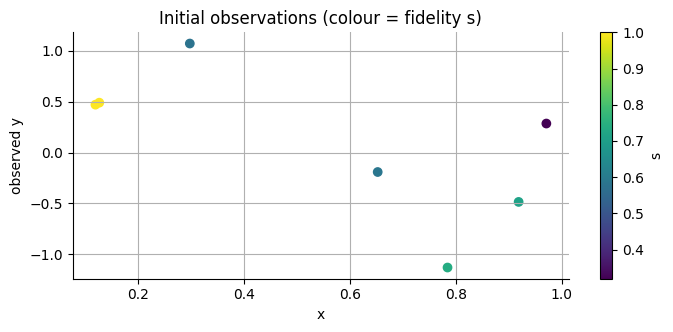

Initial total simulated cost: 8.370


In [29]:
def cost(s: torch.Tensor) -> torch.Tensor:
    return 0.1 + 2.0 * (s ** 2)

def generate_initial_data(n_low: int = 5, n_high: int = 2):
    # Low-fidelity points
    x_low = torch.rand(n_low, 1, **tkwargs)
    s_low = 0.05 + 0.75 * torch.rand(n_low, 1, **tkwargs)  # in [0.05, 0.8]
    X_low = torch.cat([x_low, s_low], dim=-1)

    # High-fidelity points
    x_high = torch.rand(n_high, 1, **tkwargs)
    s_high = torch.ones(n_high, 1, **tkwargs)
    X_high = torch.cat([x_high, s_high], dim=-1)

    X = torch.cat([X_low, X_high], dim=0)
    Y = f_mf(X, add_noise=True)

    return X, Y

train_X, train_Y = generate_initial_data()

# Visualise observations (colour by fidelity)
plt.figure()
plt.scatter(train_X[:, 0].cpu(), train_Y[:, 0].cpu(), c=train_X[:, 1].cpu())
plt.xlabel("x")
plt.ylabel("observed y")
plt.title("Initial observations (colour = fidelity s)")
plt.colorbar(label="s")
plt.show()

# Also track cost spent so far:
spent = cost(train_X[:, [1]]).sum().item()
print(f"Initial total simulated cost: {spent:.3f}")


#### 2. Multi-fidelity GP regression

BoTorch provides `SingleTaskMultiFidelityGP`, which is a GP model designed for multi-fidelity problems where fidelity is an input dimension.

Key points:

- Training inputs are augmented to include the fidelity as an additional input: $[x, s]$.
- The model specifies which input dimension is the fidelity dimension via `data_fidelities=[...]`.

For this example:
- The input dimension is 2: `[x, s]`
- The fidelity dimension index is `1`.

```python
FIDELITY_DIM = 1  # column index of s in [x, s]

def fit_mf_model(train_X: torch.Tensor, train_Y: torch.Tensor):
    model = SingleTaskMultiFidelityGP(
        train_X,
        train_Y,
        data_fidelities=[FIDELITY_DIM],
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model = fit_mf_model(train_X, train_Y)
```


In [30]:
FIDELITY_DIM = 1  # column index of s in [x, s]

def fit_mf_model(train_X: torch.Tensor, train_Y: torch.Tensor):
    model = SingleTaskMultiFidelityGP(
        train_X,
        train_Y,
        data_fidelities=[FIDELITY_DIM],
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model = fit_mf_model(train_X, train_Y)


We can observe the default kernel used for `SingleTaskMultiFidelityGP` with 

```python
print(model.covar_module.base_kernel)
```

Here, a `LinearTruncatedFidelityKernel` is used: the kernel builds the covariance with an unbiased part (for $s = 1$) and a bias part (addition for when $s < 1$) with both using `MaternKernel`

For more information, visit: 
- https://botorch.readthedocs.io/en/stable/_modules/botorch/models/kernels/linear_truncated_fidelity.html


In [31]:

print(model.covar_module.base_kernel)  # the “real” kernel underneath


ProductKernel(
  (kernels): ModuleList(
    (0): LinearTruncatedFidelityKernel(
      (raw_power_constraint): Positive()
      (power_prior): GammaPrior()
      (covar_module_unbiased): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (covar_module_biased): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
    )
  )
)


#### 3. Visualising the posterior

We can sample the posterior to plot the GP posterior mean and uncertainty conditional on a fixed fidelity value. Each slice is informed by all observed points across all fidelities.

```python
@torch.no_grad()
def plot_posterior_slices(
    model,
    train_X: torch.Tensor,
    train_Y: torch.Tensor,
    s_values=(0.2, 0.5, 1.0),
    n_grid: int = 300,
):
    xs = torch.linspace(0, 1, n_grid, **tkwargs).unsqueeze(-1)
    fig, axes = plt.subplots(1, len(s_values), figsize=(11, 3.6), sharey=True)
    scatter_handle = None

    for ax, s_val in zip(axes, s_values):
        Xg = torch.cat([xs, torch.full_like(xs, float(s_val))], dim=-1)

        post = model.posterior(Xg)
        mean = post.mean.squeeze(-1).cpu()
        std = post.variance.sqrt().squeeze(-1).cpu()

        # True function slice (noise-free)
        y_true = f_mf(Xg, add_noise=False).squeeze(-1).cpu()

        x_cpu = xs.squeeze(-1).cpu()
        ax.plot(x_cpu, y_true, label="true (noise-free)")
        ax.plot(x_cpu, mean, label="GP mean")
        ax.fill_between(
            x_cpu,
            (mean - 2 * std),
            (mean + 2 * std),
            alpha=0.2,
            label="GP ±2σ",
        )

        # Observations: colored by fidelity s
        scatter_handle = ax.scatter(
            train_X[:, 0].cpu(),
            train_Y[:, 0].cpu(),
            c=train_X[:, 1].cpu(),
            s=25,
            label="observations (color = s)",
        )

        ax.set_title(f"Posterior slice at s={s_val}")
        ax.set_xlabel("x")
        ax.grid(True, alpha=0.25)
        ax.legend(fontsize=8, loc="best")

    axes[0].set_ylabel("y")
    fig.suptitle("Multi-fidelity GP posterior slices", y=1.03)
    if scatter_handle is not None:
        cbar = fig.colorbar(scatter_handle, ax=axes, fraction=0.035, pad=0.04)
        cbar.set_label("fidelity s")

    plt.show()


plot_posterior_slices(model, train_X, train_Y)

```

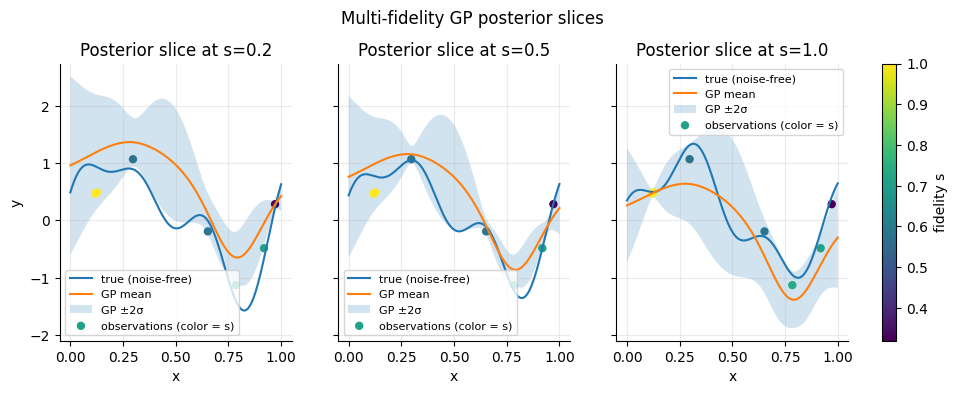

In [32]:
@torch.no_grad()
def plot_posterior_slices(
    model,
    train_X: torch.Tensor,
    train_Y: torch.Tensor,
    s_values=(0.2, 0.5, 1.0),
    n_grid: int = 300,
):
    xs = torch.linspace(0, 1, n_grid, **tkwargs).unsqueeze(-1)
    fig, axes = plt.subplots(1, len(s_values), figsize=(11, 3.6), sharey=True)
    scatter_handle = None

    for ax, s_val in zip(axes, s_values):
        Xg = torch.cat([xs, torch.full_like(xs, float(s_val))], dim=-1)

        post = model.posterior(Xg)
        mean = post.mean.squeeze(-1).cpu()
        std = post.variance.sqrt().squeeze(-1).cpu()

        # True function slice (noise-free)
        y_true = f_mf(Xg, add_noise=False).squeeze(-1).cpu()

        x_cpu = xs.squeeze(-1).cpu()
        ax.plot(x_cpu, y_true, label="true (noise-free)")
        ax.plot(x_cpu, mean, label="GP mean")
        ax.fill_between(
            x_cpu,
            (mean - 2 * std),
            (mean + 2 * std),
            alpha=0.2,
            label="GP ±2σ",
        )

        # Observations: colored by fidelity s
        scatter_handle = ax.scatter(
            train_X[:, 0].cpu(),
            train_Y[:, 0].cpu(),
            c=train_X[:, 1].cpu(),
            s=25,
            label="observations (color = s)",
        )

        ax.set_title(f"Posterior slice at s={s_val}")
        ax.set_xlabel("x")
        ax.grid(True, alpha=0.25)
        ax.legend(fontsize=8, loc="best")

    axes[0].set_ylabel("y")
    fig.suptitle("Multi-fidelity GP posterior slices", y=1.03)
    if scatter_handle is not None:
        cbar = fig.colorbar(scatter_handle, ax=axes, fraction=0.035, pad=0.04)
        cbar.set_label("fidelity s")

    plt.show()


plot_posterior_slices(model, train_X, train_Y)


#### 4. Acquisition Function

There are several possible ways of defining the acquisition functions. Here is one of many. 

Standard BO (EI/UCB/NEI/KG/MES) chooses `x` and assumes the evaluation cost is constant.

MF-BO chooses `(x, s)` and explicitly trades off:

- information / improvement about $f(x,1)$,
- cost of evaluating at fidelity $s$.

The official BoTorch MF-KG tutorial (https://botorch.org/docs/tutorials/discrete_multi_fidelity_bo/) uses:

- `qMultiFidelityKnowledgeGradient` (qMFKG)
- `AffineFidelityCostModel` (simple affine cost in fidelity dims)
- `InverseCostWeightedUtility` (utility / cost)
- `project_to_target_fidelity` (maps any X to target fidelity for “lookahead”)

The 'projection' is crucial: it tells KG what it means to care about the target fidelity.
For example, it can take a candidate $(x, s)$ and map it to $(x, 1)$.

BoTorch also emphasises that MF-KG needs a 'current value' term: it uses the current maximum posterior mean at target fidelity as a baseline. See the document for full details. 

Iter 00 | chose (x,s)=[0.13349837 0.        ] | acq=1.2341 | step_cost=0.100 | cum_cost=0.100


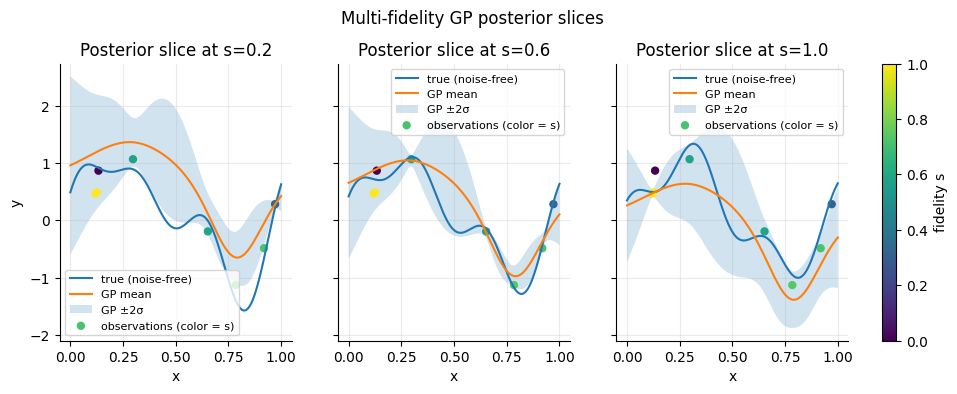

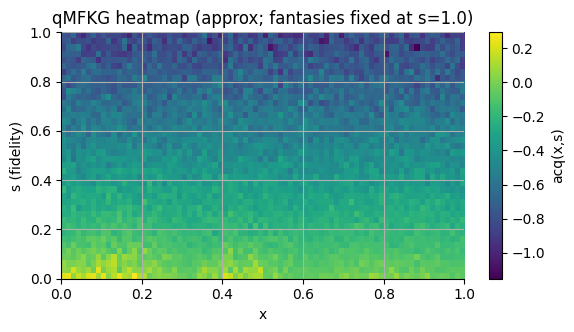

Iter 01 | chose (x,s)=[0.40828811 0.        ] | acq=1.3187 | step_cost=0.100 | cum_cost=0.200


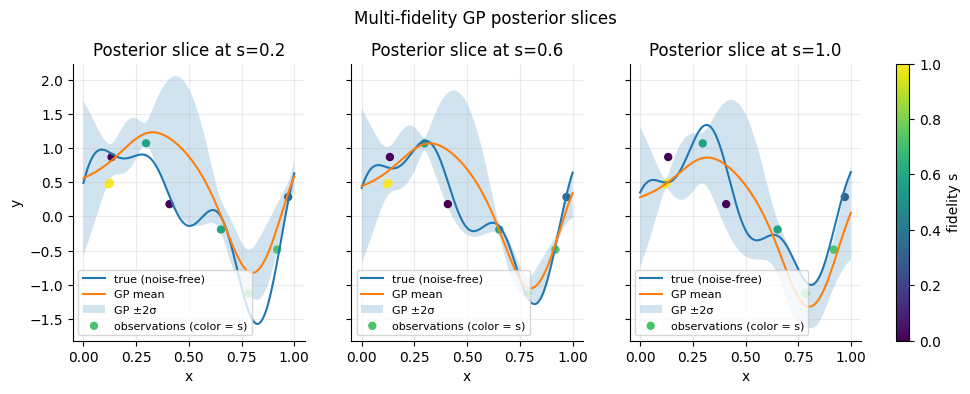

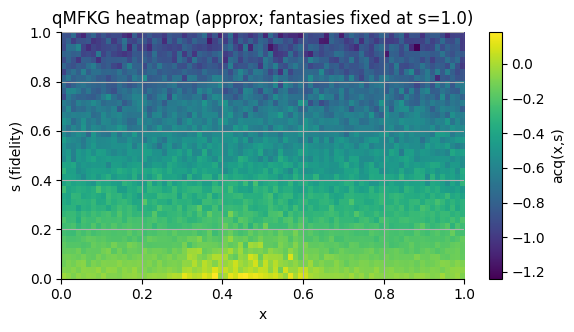

Iter 02 | chose (x,s)=[0.22845259 0.        ] | acq=0.9806 | step_cost=0.100 | cum_cost=0.300


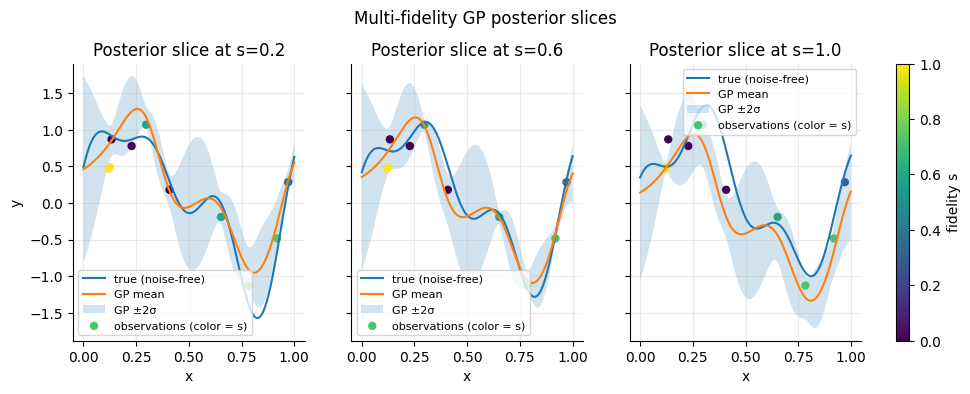

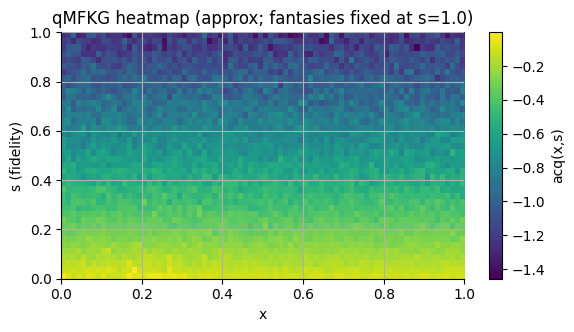

Iter 03 | chose (x,s)=[0.31614804 0.        ] | acq=0.4551 | step_cost=0.100 | cum_cost=0.400


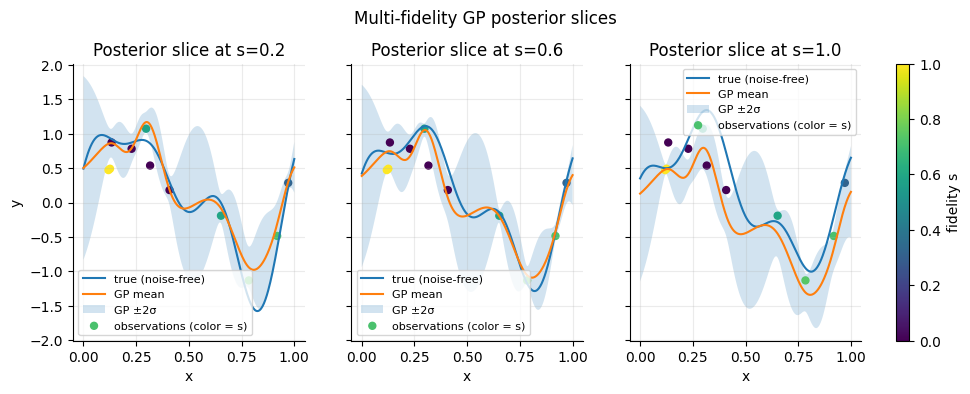

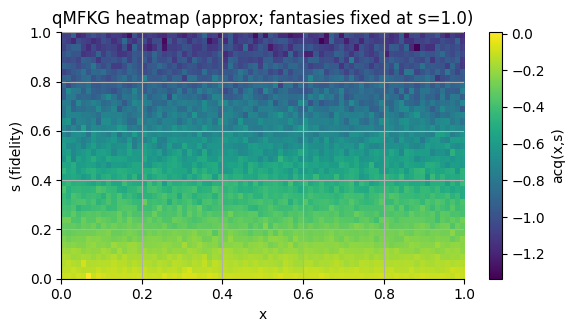

Iter 04 | chose (x,s)=[0. 0.] | acq=1.3449 | step_cost=0.100 | cum_cost=0.500


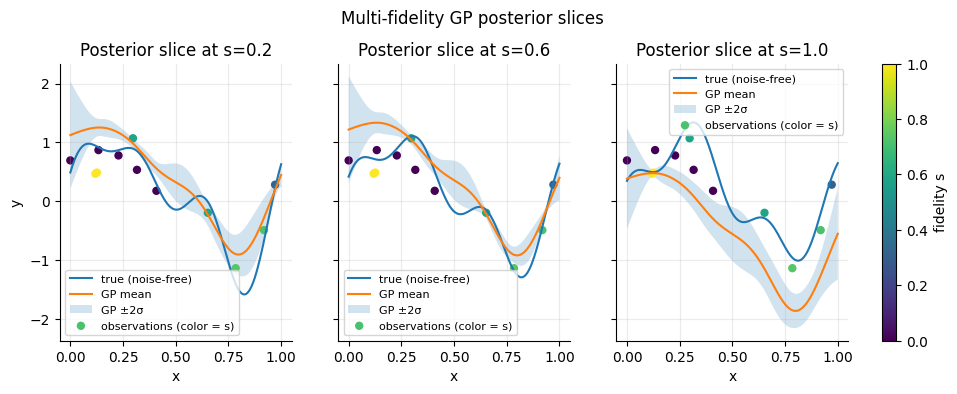

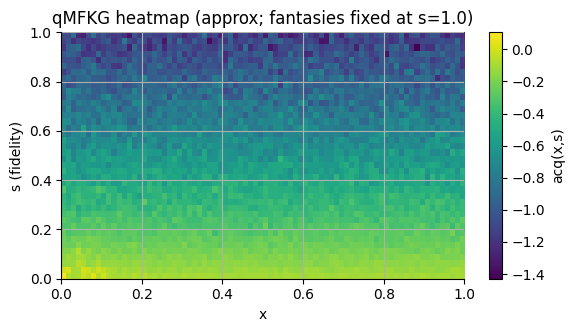

Iter 05 | chose (x,s)=[0.06509837 0.        ] | acq=0.1175 | step_cost=0.100 | cum_cost=0.600


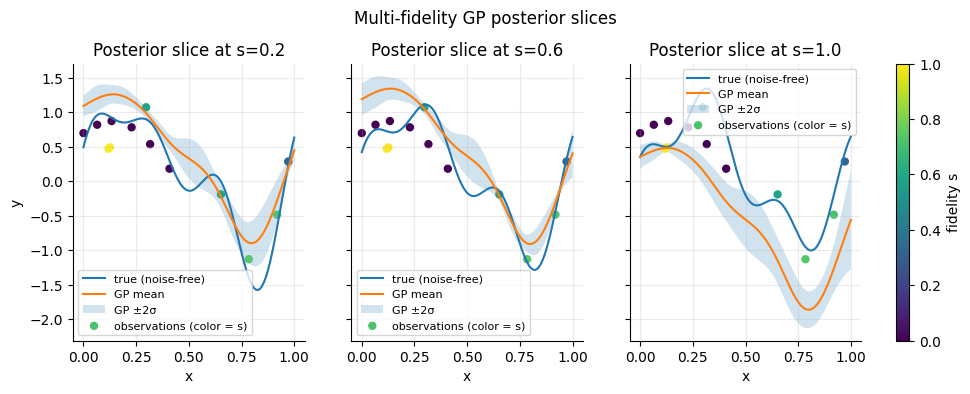

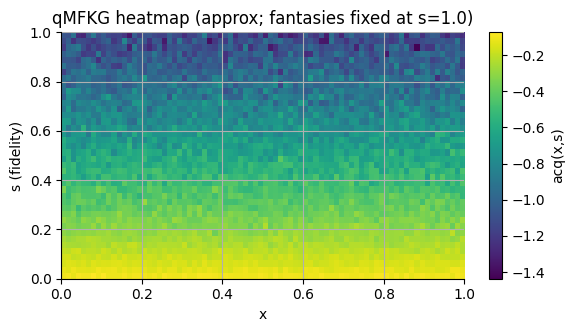

Iter 06 | chose (x,s)=[0.17509315 0.        ] | acq=0.0289 | step_cost=0.100 | cum_cost=0.700


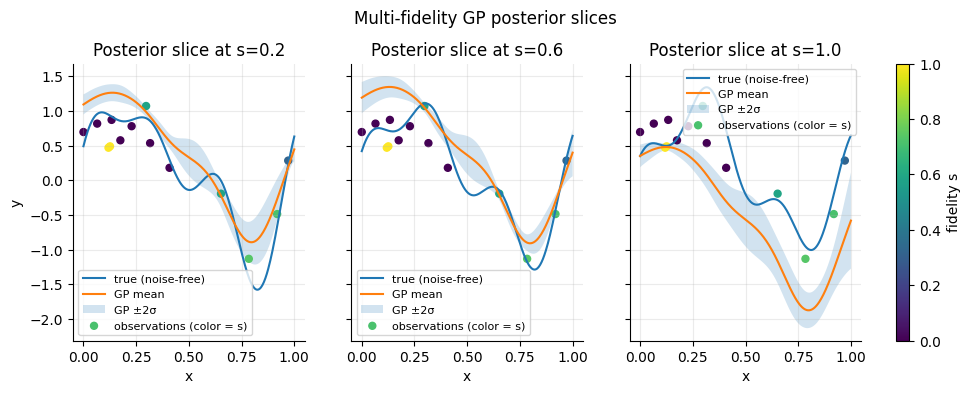

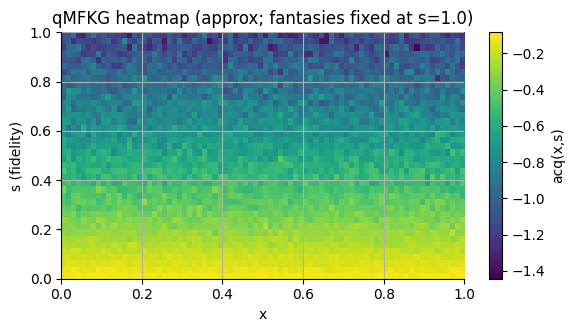

Iter 07 | chose (x,s)=[0.03595892 0.        ] | acq=0.0823 | step_cost=0.100 | cum_cost=0.800


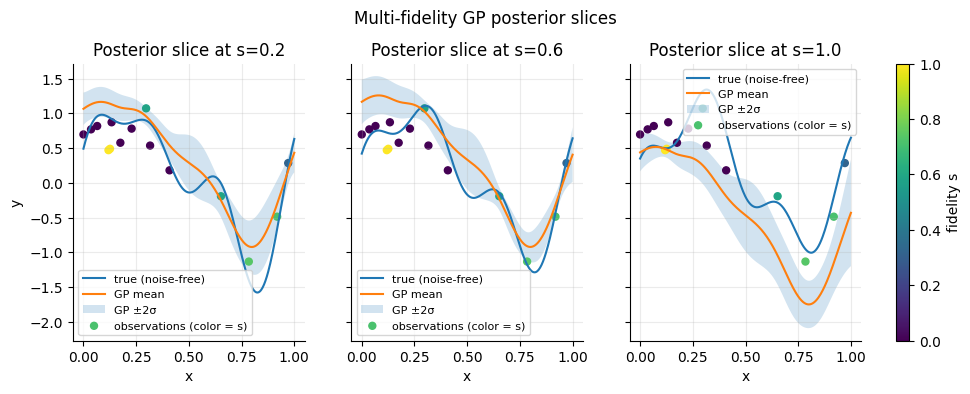

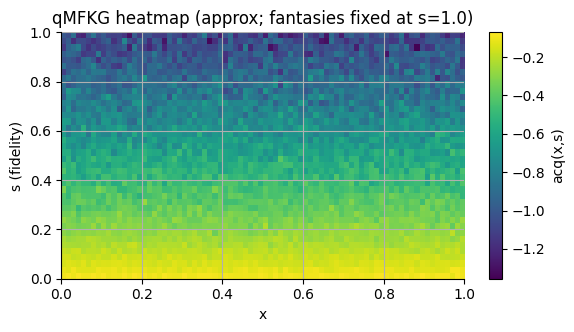

Iter 08 | chose (x,s)=[0.91303082 0.        ] | acq=0.0741 | step_cost=0.100 | cum_cost=0.900


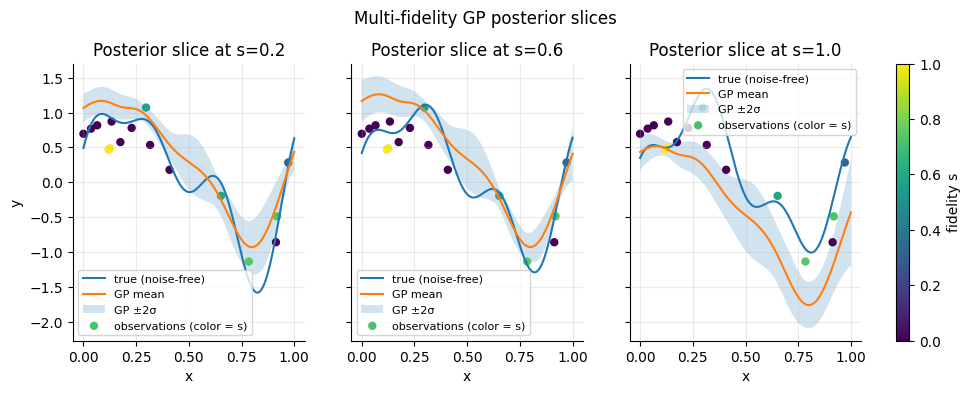

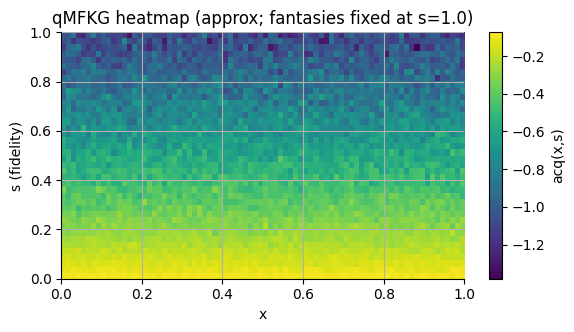

Iter 09 | chose (x,s)=[0.04785115 0.        ] | acq=0.0517 | step_cost=0.100 | cum_cost=1.000


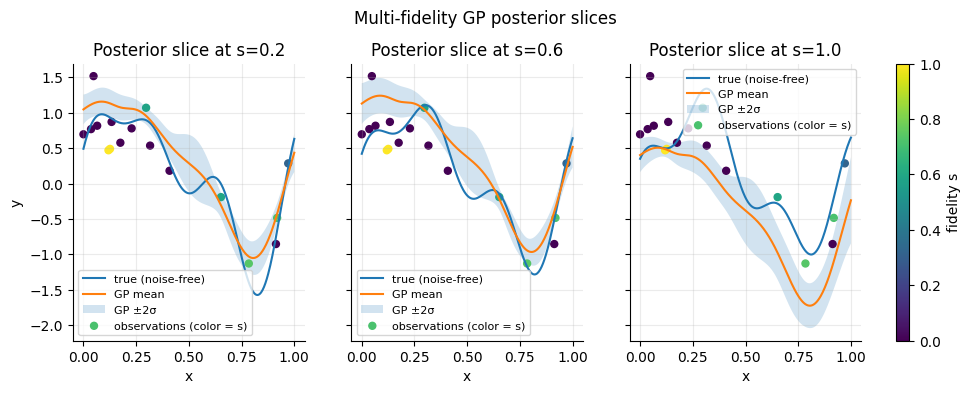

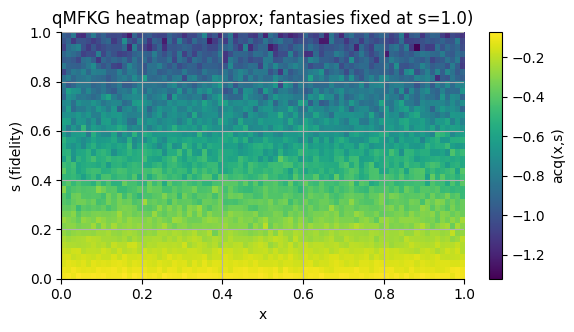

In [33]:
@dataclass
class MFLoopConfig:
    n_iter: int = 10
    q: int = 1
    num_fantasies: int = 64
    num_restarts: int = 15
    raw_samples: int = 512
    maxiter: int = 200
    plot_every: int = 1  # plot each iteration
    acq_grid_nx: int = 80
    acq_grid_ns: int = 40

cfg = MFLoopConfig()

# Full bounds (x and s)
bounds_full = torch.tensor([[0.0, 0.0], [1.0, 1.0]], **tkwargs)

# BoTorch-native cost model (affine in s): cost = fixed_cost + 1.0 * s
# This mirrors the pattern in the BoTorch tutorial, but with our toy 2D inputs.
cost_model = AffineFidelityCostModel(
    fidelity_weights={FIDELITY_DIM: 1.0},
    fixed_cost=0.1,
).to(**tkwargs)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

target_fidelities = {FIDELITY_DIM: 1.0}
def project(X: torch.Tensor) -> torch.Tensor:
    return project_to_target_fidelity(X=X, target_fidelities=target_fidelities)

def get_current_value(model) -> torch.Tensor:
    # maximise posterior mean at target fidelity -> scalar current_value
    pm = PosteriorMean(model)
    pm_fixed = FixedFeatureAcquisitionFunction(pm, d=2, columns=[FIDELITY_DIM], values=[1.0])
    _, current_value = optimize_acqf(
        acq_function=pm_fixed,
        bounds=bounds_full[:, [0]],  # only x bounds
        q=1,
        num_restarts=20,
        raw_samples=512,
        options={"maxiter": 200},
    )
    return current_value

def get_mfkg(model, current_value: torch.Tensor, cfg: MFLoopConfig):
    return qMultiFidelityKnowledgeGradient(
        model=model,
        num_fantasies=cfg.num_fantasies,
        current_value=current_value,
        cost_aware_utility=cost_aware_utility,
        project=project,
    )

@torch.no_grad()
def plot_acq_heatmap(acqf, cfg: MFLoopConfig, target_s: float = 1.0, seed: int = 0):
    # Grid over (x,s)
    xs = torch.linspace(0, 1, cfg.acq_grid_nx, **tkwargs)
    ss = torch.linspace(0, 1, cfg.acq_grid_ns, **tkwargs)
    X_grid = torch.stack(torch.meshgrid(xs, ss, indexing="ij"), dim=-1).reshape(-1, 2)
    N = X_grid.shape[0]

    # qMFKG is ONE-SHOT: it expects X with shape (t_batch, q + num_fantasies, d)
    n_f = acqf.num_fantasies
    q = 1

    # Build fixed fantasy points for every grid location (qualitative viz)
    g = torch.Generator(device=tkwargs["device"])
    g.manual_seed(seed)

    # fantasy x: random in [0,1], fantasy s: fixed at target fidelity (usually 1.0)
    x_f = torch.rand(N, n_f, 1, generator=g, **tkwargs)
    s_f = torch.full((N, n_f, 1), float(target_s), **tkwargs)
    X_fant = torch.cat([x_f, s_f], dim=-1)          # (N, n_f, 2)

    X_actual = X_grid.unsqueeze(1)                  # (N, 1, 2)
    X_aug = torch.cat([X_actual, X_fant], dim=1)    # (N, 1 + n_f, 2)

    vals = acqf(X_aug).detach().cpu().view(cfg.acq_grid_nx, cfg.acq_grid_ns)

    plt.figure(figsize=(6.5, 3.2))
    plt.imshow(vals.T, origin="lower", aspect="auto", extent=[0, 1, 0, 1])
    plt.xlabel("x")
    plt.ylabel("s (fidelity)")
    plt.title(f"qMFKG heatmap (approx; fantasies fixed at s={target_s})")
    plt.colorbar(label="acq(x,s)")
    plt.show()


def optimize_mfkg(acqf, cfg: MFLoopConfig):
    # One-shot KG benefits from a special initializer
    X_init = gen_one_shot_kg_initial_conditions(
        acq_function=acqf,
        bounds=bounds_full,
        q=cfg.q,
        num_restarts=cfg.num_restarts,
        raw_samples=cfg.raw_samples,
    )
    candidates, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds_full,
        q=cfg.q,
        num_restarts=cfg.num_restarts,
        raw_samples=cfg.raw_samples,
        batch_initial_conditions=X_init,
        options={"maxiter": cfg.maxiter, "batch_limit": 5},
    )
    return candidates.detach(), acq_value.detach()

def run_mfkg_loop(train_X, train_Y, cfg: MFLoopConfig):
    cumulative_cost = 0.0
    best_high_fidelity = []
    spent_hist = []

    for it in range(cfg.n_iter):
        model = fit_mf_model(train_X, train_Y)
        curr_val = get_current_value(model)
        acqf = get_mfkg(model, curr_val, cfg)

        X_next, acq_val = optimize_mfkg(acqf, cfg)
        Y_next = f_mf(X_next, add_noise=True)

        # "Spend" according to our BoTorch-native cost model (affine in s)
        step_cost = cost_model(X_next.unsqueeze(0)).sum().item()
        cumulative_cost += step_cost

        # Update data
        train_X = torch.cat([train_X, X_next], dim=0)
        train_Y = torch.cat([train_Y, Y_next], dim=0)

        # Track best observed *at target fidelity* among observed points
        mask_hi = (train_X[:, FIDELITY_DIM] >= 0.999)
        best_hi = train_Y[mask_hi].max().item() if mask_hi.any() else float("nan")
        best_high_fidelity.append(best_hi)
        spent_hist.append(cumulative_cost)

        print(f"Iter {it:02d} | chose (x,s)={X_next.squeeze(0).cpu().numpy()} | acq={acq_val.item():.4f} | step_cost={step_cost:.3f} | cum_cost={cumulative_cost:.3f}")

        if cfg.plot_every and (it % cfg.plot_every == 0):
            plot_posterior_slices(model, train_X, train_Y, s_values=(0.2, 0.6, 1.0))
            plot_acq_heatmap(acqf, cfg)

    return train_X, train_Y, spent_hist, best_high_fidelity

train_X2, train_Y2, spent_hist, best_hi_hist = run_mfkg_loop(train_X, train_Y, cfg)


### Multi-dimensional MFBO

For a more “real” multi-dimensional benchmark, BoTorch uses `AugmentedHartmann`:

- design dimension: 6
- fidelity dimension: 1 (7 total inputs)
- objective: maximise $ f(x, s) $ and ultimately $f(x,1)$

This section follows the structure of the official BoTorch tutorial. https://botorch.org/docs/tutorials/discrete_multi_fidelity_bo/


In [35]:
from botorch.test_functions.multi_fidelity import AugmentedHartmann

problem = AugmentedHartmann(negate=True).to(**tkwargs)
d = problem.dim  # 7 (6 design + 1 fidelity)
FID_DIM_HARTMANN = 6
bounds = torch.tensor([[0.0] * d, [1.0] * d], **tkwargs)
target_fidelities_h = {FID_DIM_HARTMANN: 1.0}

cost_model_h = AffineFidelityCostModel(fidelity_weights={FID_DIM_HARTMANN: 1.0}, fixed_cost=5.0).to(**tkwargs)
cost_aware_utility_h = InverseCostWeightedUtility(cost_model=cost_model_h)

def project_h(X):
    return project_to_target_fidelity(X=X, target_fidelities=target_fidelities_h)

def generate_initial_data_h(n=16):
    train_x = torch.rand(n, d, **tkwargs)
    train_obj = problem(train_x).unsqueeze(-1)
    return train_x, train_obj

def fit_model_h(train_x, train_obj):
    model = SingleTaskMultiFidelityGP(
        train_x,
        train_obj,
        data_fidelities=[FID_DIM_HARTMANN],
        outcome_transform=Standardize(m=1),
        input_transform=Normalize(d=d),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

def current_value_h(model):
    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=d,
        columns=[FID_DIM_HARTMANN],
        values=[1.0],
    )
    _, cv = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:, :-1],  # optimize over design dims only
        q=1,
        num_restarts=10,
        raw_samples=1024,
        options={"batch_limit": 10, "maxiter": 200},
    )
    return cv

def get_mfkg_h(model):
    cv = current_value_h(model)
    return qMultiFidelityKnowledgeGradient(
        model=model,
        num_fantasies=128,
        current_value=cv,
        cost_aware_utility=cost_aware_utility_h,
        project=project_h,
    )

def optimize_mfkg_h(mfkg):
    X_init = gen_one_shot_kg_initial_conditions(
        acq_function=mfkg,
        bounds=bounds,
        q=4,
        num_restarts=10,
        raw_samples=512,
    )
    cand, _ = optimize_acqf(
        acq_function=mfkg,
        bounds=bounds,
        q=4,
        num_restarts=10,
        raw_samples=512,
        batch_initial_conditions=X_init,
        options={"batch_limit": 5, "maxiter": 200},
    )
    new_x = cand.detach()
    new_obj = problem(new_x).unsqueeze(-1)
    step_cost = cost_model_h(cand).sum().item()
    return new_x, new_obj, step_cost

# Run a few iterations
train_x, train_obj = generate_initial_data_h(n=16)
cum_cost = 0.0
for it in range(4):
    model_h = fit_model_h(train_x, train_obj)
    mfkg = get_mfkg_h(model_h)
    new_x, new_obj, step_cost = optimize_mfkg_h(mfkg)
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    cum_cost += step_cost
    print(f"Hartmann iter {it} | step_cost={step_cost:.3f} | cum_cost={cum_cost:.3f}")

# Final recommendation at target fidelity: maximize posterior mean at s=1
model_h = fit_model_h(train_x, train_obj)
rec_acqf = FixedFeatureAcquisitionFunction(PosteriorMean(model_h), d=d, columns=[FID_DIM_HARTMANN], values=[1.0])
x_rec, _ = optimize_acqf(rec_acqf, bounds=bounds[:, :-1], q=1, num_restarts=20, raw_samples=2048)
X_rec_h = rec_acqf._construct_X_full(x_rec)

print("Recommended point (includes s=1):\n", X_rec_h.cpu().numpy())
print("True objective value at rec:", problem(X_rec_h).item())
print("Total cost:", cum_cost)


Hartmann iter 0 | step_cost=20.553 | cum_cost=20.553
Hartmann iter 1 | step_cost=20.017 | cum_cost=40.570
Hartmann iter 2 | step_cost=20.414 | cum_cost=60.984
Hartmann iter 3 | step_cost=20.308 | cum_cost=81.292
Recommended point (includes s=1):
 [[0.18385402 0.14351267 0.52101076 0.32163986 0.26630093 0.70191605
  1.        ]]
True objective value at rec: 3.0903606558873693
Total cost: 81.29206254326547
